#Статистический анализ пользователей сервиса аренды самокатов

В данном проекте я буду анализировать данные сервиса аренды самокатов GoFast. Мне доступно три датасета:
- users_go.csv — Хранит данные о пользователях (user_id, name, age, city, subscription_type)
- rides_go.csv — Данные о поездках, совершённых пользователями (user_id, distance, duration, date)
- subscriptions_go.csv — Типы подписок (subscription_type, minute_price, start_ride_price, subscription_fee)

Я произведу анализ доступных данных, чтобы ответить на следующие вопросы:
- Тратят ли пользователи с подпиской больше времени на поездки?
- Превышает ли средняя дальность поездки оптимальную с точки зрения износа самокатов?
- Приносят ли пользователи с подпиской больше выручки, чем без неё?

In [1]:
#импорт библиотек
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats as st

import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
#задание стиля диаграмм
mpl.style.use(['Solarize_Light2'])

## Загрузка данных

Сохраню датасеты в соответствующие переменные:

In [3]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

### Датасет users

Посмотрим на каждый из датасетов по отдельности. Начнём с пользователей:

In [4]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


В столбце "user_id" У нас уникальные упорядоченные идентификаторы для каждого пользователя. Также здесь есть имя каждого человека, его возраст и город. В "subscription_type" указан тип подписки: free или ultra, подробнее о типах подписок в датасете subscriptions.

In [5]:
users.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 458.7 KB


По своим размерам датасет небольшой: всего 1565 строк и пять столбцов.

### Датасет rides

Теперь посмотрим на первые пять строк таблицы rides, отражающей поезки, совершённые пользователями.

In [6]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


Данный датасет также как и users упорядочен по user_id. В этом случае благодаря этому столбцу я смогу соединить каждую конкретную поездку с пользователем, совершившим её.

In [7]:
rides.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 1.6 MB


Видно, что эта таблица уже заметно больше, чем предыдущая. Поездок в нашем датасете было совершено 18068.

### Датасет subscriptions

В этом датасете хранятся подписки. Посмотрим на них:

In [8]:
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [9]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


В этом датасете всего две строки, определяющие, что даёт каждая из двух имеющихся вариантов подписки: бесплатная и ультра.

Бесплатная:
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта — 50 рублей.

Ultra:
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

### Промежуточный вывод

Имеющиеся три датасета связаны между собой: в таблице с пользователями у каждого из них указан тип подписки, описанный в таблице с подписками, а каждая поездка относится к определённому уникальному идентификационному номеру пользователя, её совершившего.

## Предобработка данных

### Привести столбец с датой к типу datetime из библиотеки pandas

В датасете с поездками есть столбец date, отражающий дату поездки. По умолчанию, при импорте его тип установился как object, которым в pandas обозначаются строковые данные. Приведу столбец к подходящему типу.

In [10]:
rides['date'] = pd.to_datetime(rides['date'])
rides['date'].head(1)

0   2021-01-01
Name: date, dtype: datetime64[ns]

Как видно, тип данных теперь datetime.



##### Создать столбец с месяцем

Теперь использую изменённый ранее столбец date.Извлеку из него информацию о месяце и сохраню её в новый столбец month.

In [11]:
rides['month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Как видим, номер месяца теперь отображается в виде отдельного столбца. Он нам потребуется в дальнейшем анализе.



### Обработка пропущенных значений

Проверю, есть ли в наших данных пропуски:

In [12]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [13]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

Как ни странно, пропущенных значений в данных не обнаружено. Подписки в проверке не нуждаются, так как в них всего две строки.

### Обработка дубликатов

В данном подразделе я буду искать дубликаты и устранять их, если найду. Начнём с подсчёта явных дубликатов.

In [14]:
users.duplicated().sum() #Пользователи

31

In [15]:
rides.duplicated().sum() #Поездки

0

Как видим, у нас есть дубликаты в датасете с пользователями. В поездках их не оказалось, что не может не радовать.
Удалим явные дубликаты из столбца с пользователями.

In [16]:
users = users.drop_duplicates()
users.duplicated().sum()

0

Наличие неявных дубликатов мы проверить не можем, так как люди с одним и тем же именем, возрастом и городом не исключены.

##### Промежуточный вывод

В разделе предобработки данных я:
- Сменила тип столбца с датой поездки с object на datetime;
- Добавила новый столбец с  месяцем поездки;
- Убедилась в отсутствии пропусков и удалила дубликаты.

## Исследовательский анализ данных

В данном разделе я рассмотрю предложенные параметры и визуализирую их для наглядности.

### Частота встречаемости городов

Чтобы проанализировать популярность городов, создам сводную таблицу, в которой будут подсчитаны все города.

,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


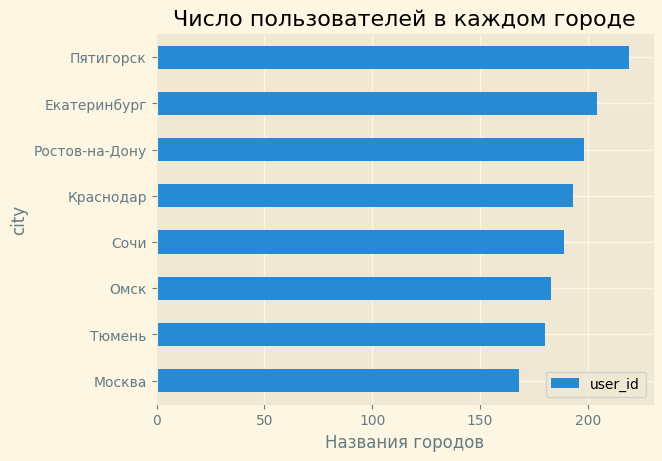

In [17]:
city_pivot = users.pivot_table(index='city', values='user_id', aggfunc='count')
city_pivot.sort_values(by='user_id').plot(kind='barh', grid=True, title='Число пользователей в каждом городе', xlabel='Названия городов');
city_pivot.sort_values(by='user_id', ascending=False)

Как видно по таблице и графику, в нашей выборке больше всего пользователей находятся в Пятигорске (219 человек) и меньше всего — в Москве (168 человек).



### Соотношение пользователей с подпиской и без подписки

Создам сводную таблицу из users по параметру subscription_type — тип подписки — и визуализирую её.

,count_of_users
subscription_type,
free,835
ultra,699


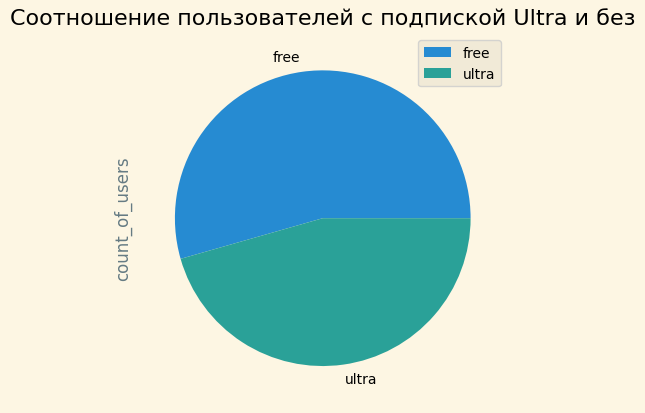

In [18]:
subs_pivot = users.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
subs_pivot.columns = ['count_of_users']
subs_pivot.plot(y='count_of_users', kind='pie', grid=True, title='Соотношение пользователей с подпиской Ultra и без');
subs_pivot

По графику видно, что пользователей без приобретённой подписки "Ultra" не намного больше, чем с ней.



### Возраст пользователей

Построю гистограмму чтобы оценить разброс пользователей по возрасту, а также выведу среднее, минимальное и максимальное значения.

Среднее = 24.903520208604956 
Минимум = 12 
Максимум = 43


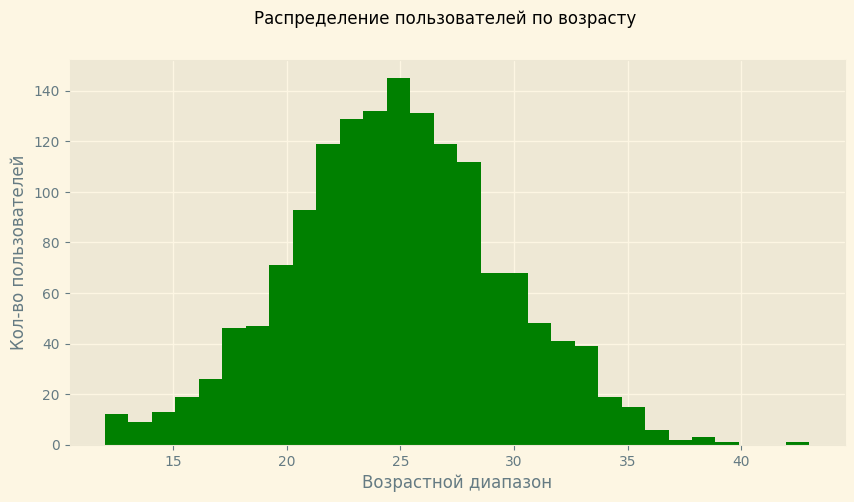

In [19]:
fig, axes = plt.subplots(1,figsize=(10,5))
axes.hist(users['age'], bins=30, color='g')
fig.suptitle('Распределение пользователей по возрасту');
axes.set_ylabel('Кол-во пользователей')
axes.set_xlabel('Возрастной диапазон')
print ('Среднее =', users['age'].mean(), '\nМинимум =', users['age'].min(), '\nМаксимум =', users['age'].max())

Распределение близко к нормальному, а потому и среднее должно быть приближено к медиане. Самому младшему пользователю сервиса 12 лет, самому старшему 43.



### Расстояние, которое пользователь преодолел за одну поездку

Чтобы оценить расстояние каждой поездки мы вновь используем гистограмму.

Среднее = 3070.66 
Минимум = 0.86 
Максимум = 7211.01


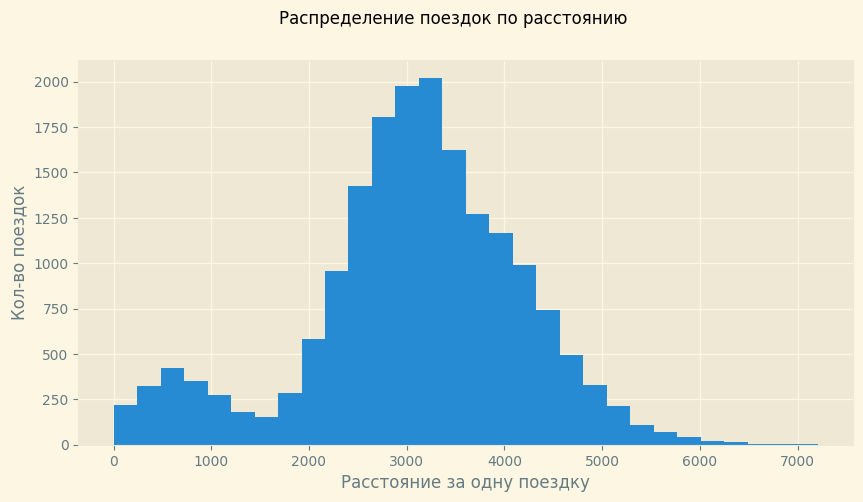

In [20]:
fig, axes = plt.subplots(1,figsize=(10,5))
axes.hist(rides['distance'], bins=30)
fig.suptitle('Распределение поездок по расстоянию');
axes.set_ylabel('Кол-во поездок')
axes.set_xlabel('Расстояние за одну поездку')
print ('Среднее =', rides['distance'].mean().round(2), '\nМинимум =', rides['distance'].min().round(2), '\nМаксимум =', rides['distance'].max().round(2))

В среднем, пользователи проезжают на самокате чуть больше трёх километров за раз. Также виден небольшой пик в районе приблизительно 600 метров. Самые короткие поездки — меньше метра, то есть, иногда люди берут самокат и тут же его сдают.



### Продолжительность поездок

Данный параметр описан в столбце duration таблицы rides. Построим для него гистограмму.

Среднее = 17.81 
Минимум = 0.5 
Максимум = 40.82


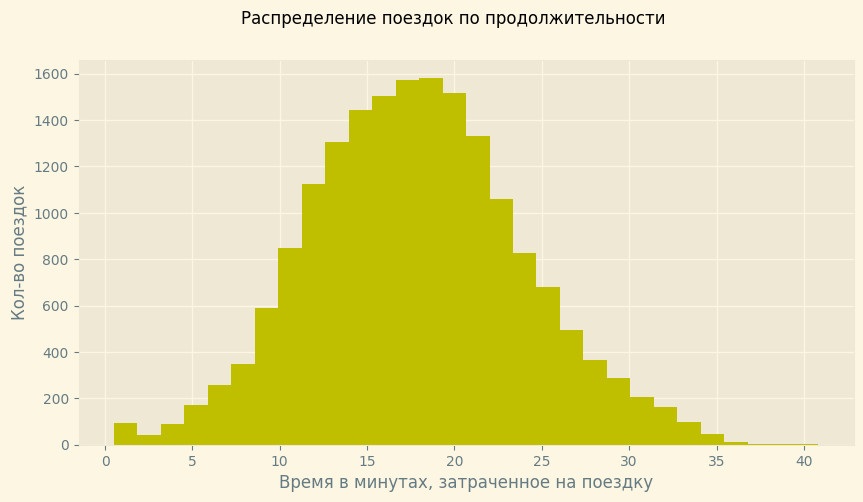

In [21]:
fig, axes = plt.subplots(1,figsize=(10,5))
axes.hist(rides['duration'], bins=30, color='y')
fig.suptitle('Распределение поездок по продолжительности');
axes.set_ylabel('Кол-во поездок')
axes.set_xlabel('Время в минутах, затраченное на поездку')
print ('Среднее =', rides['duration'].mean().round(2), '\nМинимум =', rides['duration'].min().round(2), '\nМаксимум =', rides['duration'].max().round(2))

В нашей выборке, поездки продолжаются не более сорока минут. В среднем, люди ездят около 18 минут.

### Промежуточный вывод

На третьем шаге я проводила исследовательский анализ данных и вывела следующие закономерности:

- Самый популярный по нашей выборке город — Пятигорск, Москва же находится на последнем месте;
- Большинство пользователей не приобретают подписку;
- Самый распространённый возраст пользователей — 25 лет;
- Некоторые поездки имеют совсем низкие расстояние и продолжительность: вероятно, пользователи берут самокат по ошибке, либо находят с ним какую-то неисправность, после чего тут же отменяют поездку;
- Большинство поездок длятся примерно 18 минут, за которые пользователи проезжают примерно 3 километра.

## Объединение данных

### Объединение трёх датафреймов в один

Необходимо объединить данные о пользователях, их поездках и подписках в один датайрейм. Для этого я воспользуюсь методом merge(). Создам датафрейм total_data, в него передам датафрейм rides, к которому присоединю users.

In [22]:
total_data = rides.merge(users, on='user_id', how='left')
total_data

,user_id,distance,duration,date,month,name,age,city,subscription_type
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra
...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free
18064,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free
18065,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free
18066,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free


Датафреймы с поездками и пользователями успешно объединились, теперь мы видим, какую поездку кто совершал. Присоединю также подробную информацию об их подписках.

In [23]:
total_data = total_data.merge(subscriptions, on='subscription_type', how='left')
total_data

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


Теперь мы видим не только какой пользователь совершил поездку, но и в подробностях его подписку: бесплатную или ультра.

### Датафреймы о пользователях с подпиской и без неё

Необходимо разделить получившийся датафрейм total_data на два: в один войдут только пользователи с подпиской ultra, в другой без неё. Для этого, *воспользуюсь* методом query():

In [24]:
data_ultra = total_data.query('subscription_type == "ultra"')
data_ultra

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,3973.046497,24.671163,2021-08-29,8,Оксана,22,Москва,ultra,6,0,199
6496,699,3288.702563,15.892886,2021-09-12,9,Оксана,22,Москва,ultra,6,0,199
6497,699,3076.159348,14.389525,2021-09-26,9,Оксана,22,Москва,ultra,6,0,199
6498,699,4707.845501,15.839579,2021-10-17,10,Оксана,22,Москва,ultra,6,0,199


Выше я создала датафрейм data_ultra. Как видно по выведенной таблице, пользователи там исключительно те, которые имеют подписку ultra. Сделаю такую же, но только с бесплатными пользователями.

In [25]:
data_free = total_data.query('subscription_type == "free"')
data_free

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


#### Данные о поездках пользователей с подпиской и без

Визуализирую данные о дальности и длительности поездок из созданных двух датасетов. Начну с дальности:

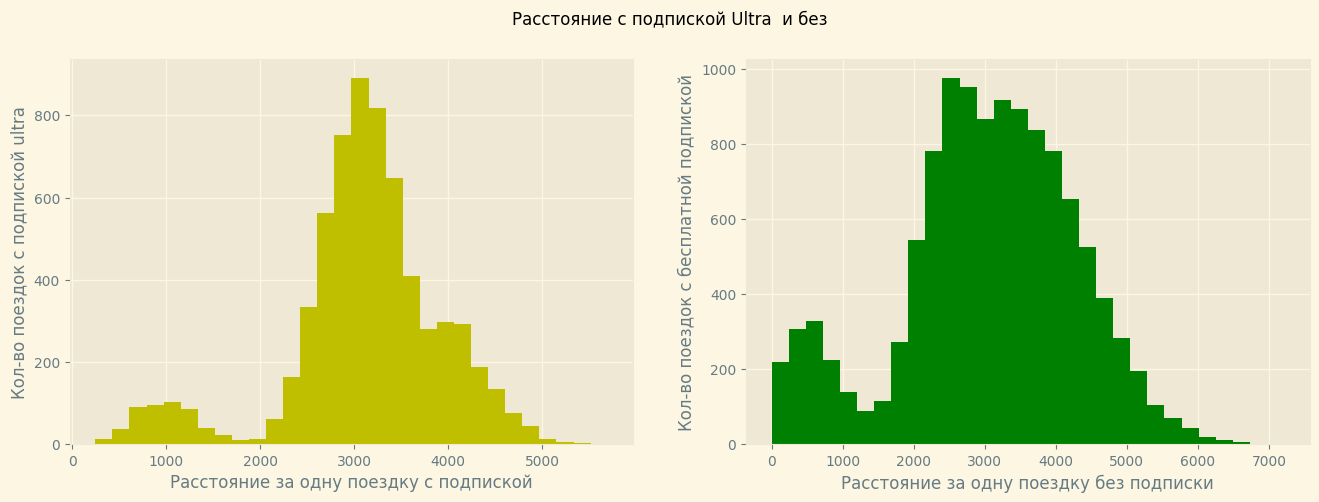

In [26]:
fig, axes = plt.subplots(1,2,figsize=(16,5))
axes[0].hist(data_ultra['distance'], bins=30, color='y')
axes[1].hist(data_free['distance'], bins=30, color='g')
axes[0].set_ylabel('Кол-во поездок с подпиской ultra')
axes[0].set_xlabel('Расстояние за одну поездку с подпиской')
axes[1].set_ylabel('Кол-во поездок с бесплатной подпиской')
axes[1].set_xlabel('Расстояние за одну поездку без подписки')
fig.suptitle('Расстояние с подпиской Ultra  и без');

Несмотря на то, что гистограмма без подписки имеет больший хвост в дальнюю сторону (свыше 7 км против 5,5 км с подпиской), отчётливо видна смещённая мода (самое частое значение). Выведем среднее обоих графиков, чтобы знать наверняка:

In [27]:
print('Среднее с подпиской:', data_ultra['distance'].mean().round(2))
print('Без подписки:', data_free['distance'].mean().round(2))

Среднее с подпиской: 3115.45
Без подписки: 3045.5


Действительно, видно, что люди без подписки имеют тенденцию совершать более короткие поездки, чем с подпиской.

Теперь оценим длительность.

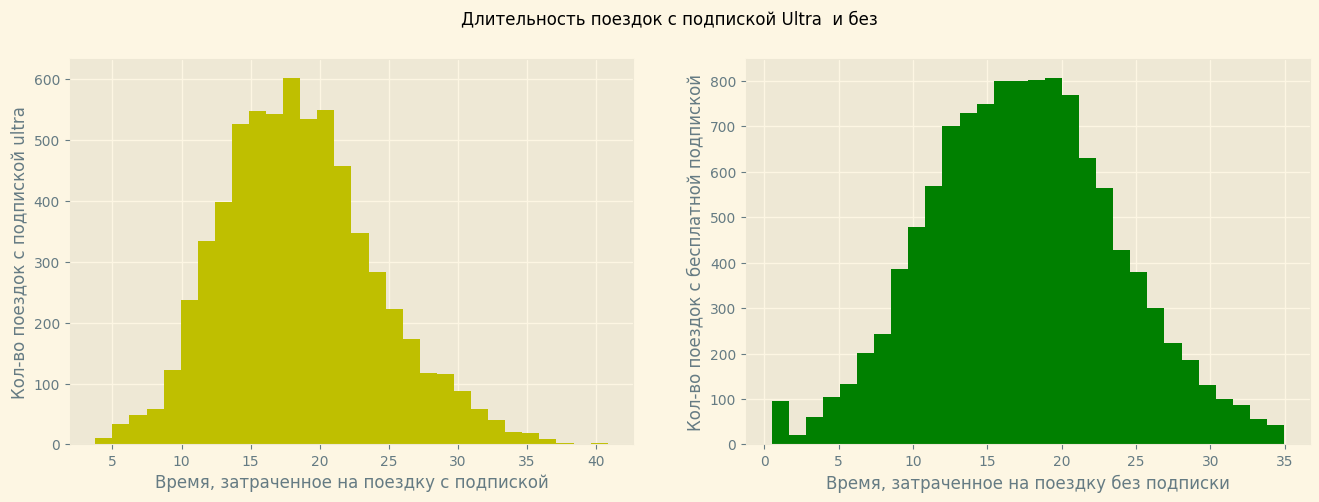

In [28]:
fig, axes = plt.subplots(1,2,figsize=(16,5))
axes[0].hist(data_ultra['duration'], bins=30, color='y')
axes[1].hist(data_free['duration'], bins=30, color='g')
axes[0].set_ylabel('Кол-во поездок с подпиской ultra')
axes[0].set_xlabel('Время, затраченное на поездку с подпиской')
axes[1].set_ylabel('Кол-во поездок с бесплатной подпиской')
axes[1].set_xlabel('Время, затраченное на поездку без подписки')
fig.suptitle('Длительность поездок с подпиской Ultra  и без');

Сами по себе эти графики не такие наглядные, разве что интересно выглядит резкий подъём около нуля в длительности поездок без подписки. Сравним средние:

In [29]:
print('Среднее с подпиской:', data_ultra['duration'].mean().round(2))
print('Без подписки:', data_free['duration'].mean().round(2))

Среднее с подпиской: 18.54
Без подписки: 17.39


Как видно, и тут значение без подписки ниже, чем с подпиской.

### Промежуточный вывод

На этом шаге мы объединили данные из трёх датасетов, а затем разделили их по признаку наличия или отсутствия у пользователя подписки ultra.

После этого мы проанализировали информацию о времени поездок и расстоянии, которое пользователь преодолел за одну поездку.

Cуммируя результаты анализа обоих параметров дальности и длительности можно сказать, что пользователи, которые не покупают подписку ultra ездят более короткие поездки. Возможно, это связано со стоимостью: в подписке ultra стоимость одной минуты езды составляет всего 6 рублей, тогда как без подписки приходится платить 8 рублей.

## Подсчёт выручки

### Группировка по пользователям и месяцам

В предыдущем шаге я создавала общий датафрейм из трёх исходных, назвав его total_data. Теперь нужно сгруппировать данные из него по пользователям и месяцам.

Сперва округлю значения дистанции и продолжительности до целых значений. Затем подсчитаю суммарные расстояния и длительности поездок для каждого отдельного пользователя.

In [30]:
total_data[['distance', 'duration']] = np.ceil(total_data[['distance', 'duration']]) #округление

In [31]:
dist_dur_pivot = total_data.pivot_table(index=['user_id', 'month'], values=['distance', 'duration'], aggfunc='sum')
dist_dur_pivot

distance  duration
user_id month                    
1       1        7028.0      42.0
        4         755.0       7.0
        8        6724.0      46.0
        10       5811.0      32.0
        11       7005.0      56.0
...                 ...       ...
1534    6        3411.0      26.0
        8        7623.0      48.0
        9        4929.0      23.0
        11      13353.0      78.0
        12       2372.0      16.0

[11331 rows x 2 columns]

Теперь сделаю ещё одну сводную таблицу, которая будет хранить количество поездок.

In [32]:
count_pivot = total_data.pivot_table(index=['user_id', 'month'], values='date', aggfunc='count')
count_pivot.columns = ['count_of_rides']
count_pivot

count_of_rides
user_id month                
1       1                   2
        4                   1
        8                   2
        10                  2
        11                  3
...                       ...
1534    6                   2
        8                   2
        9                   1
        11                  4
        12                  1

[11331 rows x 1 columns]

Объединю две получившиеся таблицы.

In [33]:
total_grouped = dist_dur_pivot.merge(count_pivot, on=['user_id', 'month'], how='left')
total_grouped

distance  duration  count_of_rides
user_id month                                    
1       1        7028.0      42.0               2
        4         755.0       7.0               1
        8        6724.0      46.0               2
        10       5811.0      32.0               2
        11       7005.0      56.0               3
...                 ...       ...             ...
1534    6        3411.0      26.0               2
        8        7623.0      48.0               2
        9        4929.0      23.0               1
        11      13353.0      78.0               4
        12       2372.0      16.0               1

[11331 rows x 3 columns]

К полученному датафрейму прибавлю из исходного информацию о стоимости минуты, старта и подписки. Они потребуются мне для дальнейших подсчётов.

In [34]:
total_grouped = total_grouped.merge(total_data[['user_id', 'month', 'minute_price',
                                                'start_ride_price', 'subscription_fee']], on=['user_id', 'month'])
total_grouped = total_grouped.drop_duplicates().reset_index(drop=True)
total_grouped

,user_id,month,distance,duration,count_of_rides,minute_price,start_ride_price,subscription_fee
0,1,1,7028.0,42.0,2,6,0,199
1,1,4,755.0,7.0,1,6,0,199
2,1,8,6724.0,46.0,2,6,0,199
3,1,10,5811.0,32.0,2,6,0,199
4,1,11,7005.0,56.0,3,6,0,199
...,...,...,...,...,...,...,...,...
11326,1534,6,3411.0,26.0,2,8,50,0
11327,1534,8,7623.0,48.0,2,8,50,0
11328,1534,9,4929.0,23.0,1,8,50,0
11329,1534,11,13353.0,78.0,4,8,50,0


### Подсчёт выручки с каждого пользователя за месяц


Добавлю столбец gain, в котором подсчитаю прибыль с каждого отдельного пользователя по следующей формуле:

(продолжительность * стоимость_минуты) + (кол-во_поездок * стоимость старта) + стоимость_подписки

In [35]:
total_grouped['gain'] = total_grouped['duration'] * total_grouped['minute_price'] + total_grouped['count_of_rides'] * total_grouped['start_ride_price'] + total_grouped['subscription_fee']
total_grouped

,user_id,month,distance,duration,count_of_rides,minute_price,start_ride_price,subscription_fee,gain
0,1,1,7028.0,42.0,2,6,0,199,451.0
1,1,4,755.0,7.0,1,6,0,199,241.0
2,1,8,6724.0,46.0,2,6,0,199,475.0
3,1,10,5811.0,32.0,2,6,0,199,391.0
4,1,11,7005.0,56.0,3,6,0,199,535.0
...,...,...,...,...,...,...,...,...,...
11326,1534,6,3411.0,26.0,2,8,50,0,308.0
11327,1534,8,7623.0,48.0,2,8,50,0,484.0
11328,1534,9,4929.0,23.0,1,8,50,0,234.0
11329,1534,11,13353.0,78.0,4,8,50,0,824.0


### Промежуточный вывод

На данном шаге мною были сгруппированы данные по признакам id пользователей и номера месяца. Для каждого месяца была подсчитана сумма проеханных метров и минут, количество поездок. Вся эта информация была использована для подсчёта выручки, полученной с каждого человека в конкретный месяц.

## Проверка гипотез

### Тратят ли пользователи с подпиской больше времени на поездки

Гипотеза: Пользователи с подпиской тратят на поездки столько же времени, сколько и пользователи без подписки

Альтернативная гипотеза: Пользователи с подпиской тратят на поездки больше времени

In [36]:
alpha = 0.05 #уровень статистической значимости

results = st.ttest_ind(total_data.query('subscription_type == "ultra"')['duration'], total_data.query('subscription_type == "free"')['duration'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: пользователи с подпиской ездят больше времени, чем без неё')
else:
    print('Не получилось отвергнуть нулевую гипотезу: пользователи с подпиской ездят столько же, сколько без подписки')

p-значение: 2.4959453720736625e-34
Отвергаем нулевую гипотезу: пользователи с подпиской ездят больше времени, чем без неё


### Превышает ли средняя дальность поездки 3130 метров

Гипотеза: Средняя дальность поездки равна 3130 метров

Альтернативная гипотеза: Средняя дальность поездки больше 3130 метров

In [37]:
alpha = 0.05

value = 3130

results = st.ttest_1samp(data_ultra['distance'], value, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: Средняя дальность поездки превышает порог в 3130 метров')
else:
    print('Не получилось отвергнуть нулевую гипотезу: Средняя дальность поездки не превышает 3130 метров')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу: Средняя дальность поездки не превышает 3130 метров


### Будет ли помесячная выручка от пользователей с подпиской выше, чем без неё

Гипотеза: Выручка от пользователей с подпиской равна выручке от пользователей без подписки

Альтернативная гипотеза: Выручка выше от пользователей без подписки

In [38]:
alpha = 0.05 #уровень статистической значимости

results = st.ttest_ind(total_grouped.query('subscription_fee == 199')['gain'], total_grouped.query('subscription_fee == 0')['gain'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: Выручка от пользователей без подписки выше')
else:
    print('Не получилось отвергнуть нулевую гипотезу: Выручка от пользователей с подпиской ultra равна выручке без неё')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу: Выручка от пользователей без подписки выше


Как видно, пользователи с подпиской не приносят больше прибыли, чем пользователи без неё.



### Ответ на вопрос

Вопрос: Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Ответ: Поскольку нужно сравнить две связанные между собой генеральные совокупности, я воспользовалась бы методом ttest_rel().

## Вывод

В данном проекте я провела следующую работу над данными:

- Предобработка данных: мною были импортированы три датасета, изменён тип столбца с датой поездки на datetime, выведен месяц поездки в отдельный столбец month, обработаны пропущенные значения и дубликаты;
- Исследовательский анализ данных: проанализированы популярность городов, соотношение пользователей с подписками ultra и free, возрастной разброс пользователей, расстояние и продолжительность их поездок;
- Объединение данных: три исходных датафрейма я объединила в общий, затем разделила его на два: поездки пользователей с подпиской и без неё;
- Подсчёт выручки: на данном этапе я собрала данные поездок по пользователям, совершившим их, затем высчитала суммарные дальность и продолжительность, количество поездок и тип подписки. Всю эту информацию я использовала для подсчёта выручки по каждому отдельно взятому пользователю;
- Проверка гипотез: на последнем шаге проекта я использовала работу, проделанную на предыдущих этапах, чтобы ответить на вопросы, поставленные в самом начале.

И вывела следующие гипотезы:

- Пользователи с подпиской ultra действительно тратят больше времени в поездках, чем пользователи без подписки;
- Средняя дальность поездки не превышает 3130 метров — рекомендуемой дальности поездки с точки зрения износа самоката;
- Выручка от пользователей с подпиской ultra оказалась ниже, чем от пользователей без подписки. Вероятно, это связано с большей стоимостью каждой минуты и самого старта.